In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from sklearn.linear_model import LinearRegression

In [2]:
companies = pd.read_csv("companies_rated.csv")

In [3]:
companies

,company_id,region,country,exchange,industry,company_name,ticker,trading_status
0,4455588,Africa / Middle East,Bahrain,BAX,Banks,Bank of Bahrain and Kuwait B.S.C.,BBK,Active
1,883038,Africa / Middle East,Egypt,CASE,Banks,Commercial International Bank (Egypt) S.A.E,COMI,Active
2,2472872,Africa / Middle East,Egypt,CASE,Capital Markets,EFG-Hermes Holding S.A.E,HRHO,Active
3,46263794,Africa / Middle East,Egypt,CASE,Capital Markets,Pioneers Holding Company For Financial Investm...,PIOH,Active
4,32339123,Africa / Middle East,Egypt,CASE,Capital Markets,Qalaa Holdings S.A.E.,CCAP,Active
...,...,...,...,...,...,...,...,...
7818,93339,United States and Canada,United States,NasdaqGS,Wireless Telecommunication Services,"T-Mobile US, Inc.",TMUS,Active
7819,379316,United States and Canada,United States,NasdaqGS,Wireless Telecommunication Services,VEON Ltd.,VEON,Active
7820,13757558,United States and Canada,United States,OTCPK,IT Services,"GTT Communications, Inc.",GTTN,Active
7821,874816,United States and Canada,United States,OTCPK,Media,Axel Springer SE,AXEL.F,Active


## Analisando a frequência de cada setor no dataset

<AxesSubplot:>

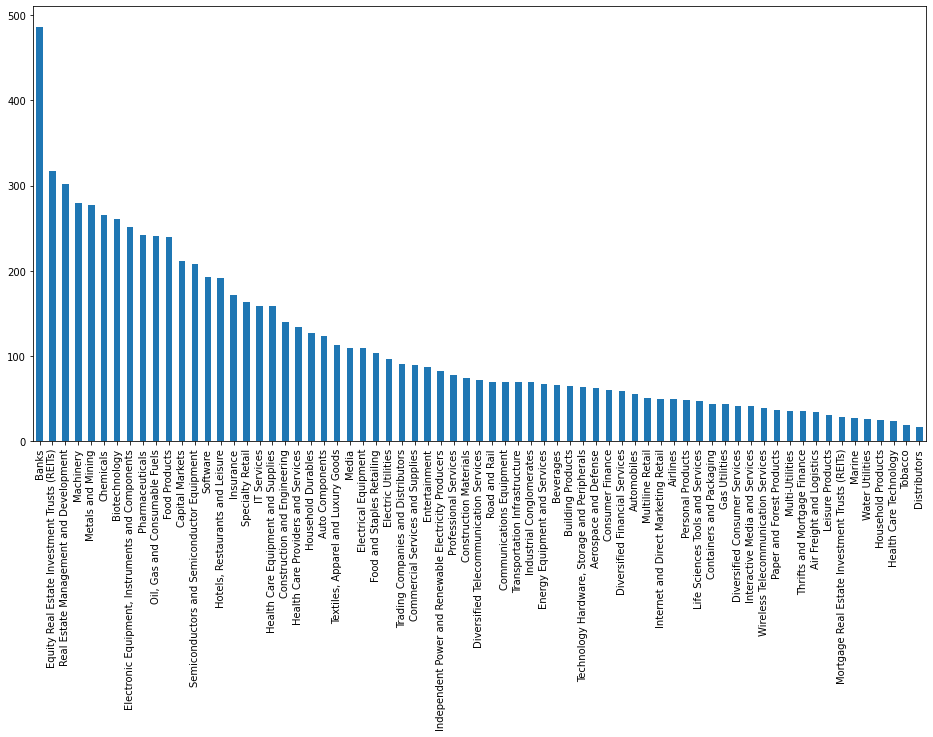

In [4]:
plt.figure(figsize=(16,8))
companies["industry"].value_counts().plot(kind='bar')

In [5]:
companies["industry"].nunique()

69

### Percebemos que tem uma desigualdade na quantidade de empresas por setor, o que poderia criar um viés nos modelos de clusterização

## Analisando o ESG

In [6]:
esg_data = pd.read_csv("esg_scores_history_rated.csv")

In [7]:
esg_data["assessment_year"] = pd.to_datetime(esg_data["assessment_year"],format="%Y")
esg_data.fillna(0,inplace=True)

In [8]:
dimensions = esg_data["parent_aspect"].unique()
dimensions

array(['Environmental Dimension', 'Governance & Economic Dimension',
       'S&P Global ESG Score', 'Social Dimension', 0], dtype=object)

In [9]:
esg_data

,assessment_year,industry,company_id,parent_aspect,aspect,score_weight,score_value
0,2013-01-01,AIR Airlines,31726,Environmental Dimension,Environmental Policy & Management Systems,8,43.400000
1,2013-01-01,AIR Airlines,31726,Environmental Dimension,Environmental Reporting,7,40.250000
2,2013-01-01,AIR Airlines,31726,Environmental Dimension,Operational Eco-Efficiency,11,32.400000
3,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Antitrust Policy,3,55.750000
4,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Brand Management,4,23.000000
...,...,...,...,...,...,...,...
844373,2020-01-01,TSV IT services,584499446,Social Dimension,Human Rights,3,0.000000
844374,2020-01-01,TSV IT services,584499446,Social Dimension,Labor Practice Indicators,4,7.200000
844375,2020-01-01,TSV IT services,584499446,Social Dimension,Social Reporting,4,0.000000
844376,2020-01-01,TSV IT services,584499446,Social Dimension,Talent Attraction & Retention,7,25.000000


## Analisando como se comporta a distribuição dos scores por dimensão Ambiental, Governança, Social e do Global ESG 

<AxesSubplot:xlabel='parent_aspect', ylabel='score_value'>

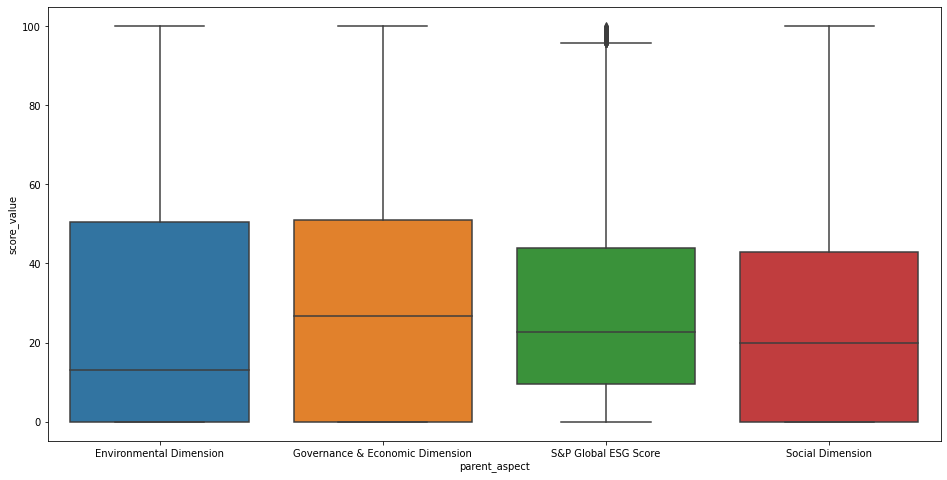

In [10]:
plt.figure(figsize=(16,8))
sns.boxplot(x="parent_aspect",y="score_value",data=esg_data[esg_data["parent_aspect"] != 0])

### Vemos que a distribuição aparenta ser similar, embora para a questão ambiental a mediana parece estar mais afastada das demais. Isso é um possível indicativo de que a questão ambiental ainda não é uma preocupação das empresas

# Vamos agora construir um modelo tal que, com base nas observações passadas, consiga predizer o score de cada uma das componentes do ESG

In [11]:
## FUNCAO QUE DADO UM DATAFRAME FAZ A MEDIA PONDERADA
def singleSum(df):
    total = 0
    denom = 0
    for i,row in df.iterrows():
        w = row["score_weight"]
        if row["score_value"] != np.nan:
            total += row["score_value"]*w
        denom += w
    return total/denom

#### Pequeno teste

In [12]:
dimensions_weights = {}
mask = (esg_data["parent_aspect"] == "Governance & Economic Dimension") & (esg_data["company_id"] == 31726)
s = esg_data[mask].groupby("assessment_year").apply(singleSum)

In [13]:
s

assessment_year
2013-01-01    44.491053
2014-01-01    47.705467
2015-01-01    44.098280
2016-01-01    40.533114
2017-01-01    46.407925
2018-01-01    32.640737
2019-01-01    32.846734
2020-01-01    36.674379
dtype: float64

In [14]:
esg_data[mask]

,assessment_year,industry,company_id,parent_aspect,aspect,score_weight,score_value
3,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Antitrust Policy,3,55.750000
4,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Brand Management,4,23.000000
5,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Codes of Business Conduct,6,58.900000
6,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Corporate Governance,5,81.143270
7,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Customer Relationship Management,4,31.540000
...,...,...,...,...,...,...,...
616705,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Policy Influence,2,43.160000
616706,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Privacy Protection,2,27.076000
616707,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Reliability,3,34.207981
616708,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Risk & Crisis Management,4,11.890000


In [15]:
esg_data[esg_data["parent_aspect"].isna()]["aspect"].unique()

array([], dtype=object)

In [16]:
esg_data[mask]["score_value"].isnull().sum()

0

In [17]:
def fillSeries(df):
    idx = pd.period_range(start=df.index.min(),end=df.index.max(),freq="A")
    df = df.reindex(idx, fill_value=np.nan)
    return df.interpolate()

def makeSeries(df):
    df = df.sort_values(by="Environmental Dimension")
    s = df.set_index("Environmental Dimension")["assessment_year"]
    s = s.to_period('A')
    s = fillSeries(s)
    return s

In [18]:
## FUNCAO QUE COMPUTA O SCORE DE UMA DADA EMPRESA, NUMA DADA DIMENSÃO, E FAZ A PREVISÃO DO SCORE
def computeScore(dimension,company_id,esg_data):
    if dimension == 'S&P Global ESG Score':
        type_ = "aspect"
    else:
        type_ = "parent_aspect"
    mask = (esg_data[type_] == dimension) & (esg_data["company_id"] == company_id)
    s = esg_data[mask].groupby("assessment_year").apply(singleSum)
#     s = fillSeries(s)
    future_score = 0
    len_s = len(s)
    #O ExponentialSmoothing nao consegue fazer fit com menos de 10 pontos
    if len_s > 1:
#         model = ExponentialSmoothing(s)
        model = SimpleExpSmoothing(s)
        model.fit()
        future_score = model.predict(model.params)[0]
    else:
        future_score = s[-1]
    return future_score

In [19]:
def computeScores(company_id,esg_data):
    future_scores = {}
    dims = esg_data["parent_aspect"].unique()[:4]
    for dimension in dims:
        future_scores[dimension] = computeScore(dimension,company_id,esg_data)
    return future_scores

#### Pequeno teste

In [20]:
computeScores(31726,esg_data)

/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning

{'Environmental Dimension': 48.380099030658194,
 'Governance & Economic Dimension': 35.983447916430066,
 'S&P Global ESG Score': 39.51344019215944,
 'Social Dimension': 30.746574658717535}

In [21]:
mask = (esg_data["parent_aspect"] == "Governance & Economic Dimension") & (esg_data["company_id"] == 31726)
esg_data[mask]

,assessment_year,industry,company_id,parent_aspect,aspect,score_weight,score_value
3,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Antitrust Policy,3,55.750000
4,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Brand Management,4,23.000000
5,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Codes of Business Conduct,6,58.900000
6,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Corporate Governance,5,81.143270
7,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Customer Relationship Management,4,31.540000
...,...,...,...,...,...,...,...
616705,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Policy Influence,2,43.160000
616706,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Privacy Protection,2,27.076000
616707,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Reliability,3,34.207981
616708,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Risk & Crisis Management,4,11.890000


## Para prova de conceito, vamos fazer uma amostragem de alguns setores e efetuar os cálculos para ela

In [22]:
# sectors = companies["industry"].unique()
sectors = ['Oil, Gas and Consumable Fuels','Metals and Mining','Road and Rail','Textiles, Apparel and Luxury Goods']
# min_sector_freq = companies["industry"].value_counts().min()
min_sector_freq = 5
sample = companies[companies["industry"].isin(sectors)].groupby('industry').apply(lambda s: s.sample(min_sector_freq))[["company_id","industry","company_name"]]
sample

company_id  \
industry                                              
Metals and Mining                  7586      301040   
                                   5178      874225   
                                   4989      299199   
                                   5176      877853   
                                   302       791281   
Oil, Gas and Consumable Fuels      3797      882231   
                                   3878    12935063   
                                   4196    28895985   
                                   5565      280420   
                                   76       5939086   
Road and Rail                      5201    34177478   
                                   854     39928186   
                                   5610      876067   
                                   7643    12632379   
                                   3272     2482177   
Textiles, Apparel and Luxury Goods 6702   143971118   
                                   7791    34125194   
                                   7788    13639284   
                                   1130    83282135   
                                   4085      877829   

                                                                   industry  \
industry                                                                      
Metals and Mining                  7586                   Metals and Mining   
                                   5178                   Metals and Mining   
                                   4989                   Metals and Mining   
                                   5176                   Metals and Mining   
                                   302                    Metals and Mining   
Oil, Gas and Consumable Fuels      3797       Oil, Gas and Consumable Fuels   
                                   3878       Oil, Gas and Consumable Fuels   
                                   4196       Oil, Gas and Consumable Fuels   
                                   5565       Oil, Gas and Consumable Fuels   
                                   76         Oil, Gas and Consumable Fuels   
Road and Rail                      5201                       Road and Rail   
                                   854                        Road and Rail   
                                   5610                       Road and Rail   
                                   7643                       Road and Rail   
                                   3272                       Road and Rail   
Textiles, Apparel and Luxury Goods 6702  Textiles, Apparel and Luxury Goods   
                                   7791  Textiles, Apparel and Luxury Goods   
                                   7788  Textiles, Apparel and Luxury Goods   
                                   1130  Textiles, Apparel and Luxury Goods   
                                   4085  Textiles, Apparel and Luxury Goods   

                                                                         company_name  
industry                                                                               
Metals and Mining                  7586                              Royal Gold, Inc.  
                                   5178                                     Vale S.A.  
                                   4989                               Rio Tinto Group  
                                   5176                       Metalurgica Gerdau S.A.  
                                   302               Impala Platinum Holdings Limited  
Oil, Gas and Consumable Fuels      3797   Bangchak Corporation Public Company Limited  
                                   3878                                    Euronav NV  
                                   4196                               CropEnergies AG  
                                   5565                                 Enbridge Inc.  
                                   76             Isramco Negev 2 Limited Partnership  
Road and Rail                      

### Computa os escores do ESG e salva num dataframe

In [23]:
ids = sample["company_id"]
scores_df = []
for id_ in ids:
    data=computeScores(id_,esg_data)
    data["company_id"] = np.int64(id_)
    scores_df.append(data)

/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date inde

/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning

/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date inde

/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date inde

/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1444: RuntimeWarning: invalid value encountered in double_scalars
  aicc = aic + aicc_penalty
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1445: RuntimeWarning: divide by zero encountered in log


/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning

In [24]:
scores_df = pd.DataFrame(scores_df).fillna(0)
scores_df

,Environmental Dimension,Governance & Economic Dimension,S&P Global ESG Score,Social Dimension,company_id
0,3.028125,33.739384,14.676735,2.168571,301040
1,81.333076,47.313645,48.876667,43.367523,874225
2,72.070274,68.052809,67.766448,66.829411,299199
3,0.000008,0.494118,0.648000,1.454545,877853
4,61.911956,40.108701,47.687520,41.688676,791281
5,39.359050,50.717644,69.952986,70.179995,882231
6,9.157778,23.411066,10.838541,2.490301,12935063
7,10.756892,24.068336,14.713365,9.129986,28895985
8,53.008639,61.885761,54.286331,46.168713,280420
9,0.000000,6.062919,2.546426,0.000000,5939086


### Junta os scores com outros dados da empresa

In [25]:
sample = sample.merge(scores_df,left_on="company_id",right_on="company_id")
sample

,company_id,industry,company_name,Environmental Dimension,Governance & Economic Dimension,S&P Global ESG Score,Social Dimension
0,301040,Metals and Mining,"Royal Gold, Inc.",3.028125,33.739384,14.676735,2.168571
1,874225,Metals and Mining,Vale S.A.,81.333076,47.313645,48.876667,43.367523
2,299199,Metals and Mining,Rio Tinto Group,72.070274,68.052809,67.766448,66.829411
3,877853,Metals and Mining,Metalurgica Gerdau S.A.,0.000008,0.494118,0.648000,1.454545
4,791281,Metals and Mining,Impala Platinum Holdings Limited,61.911956,40.108701,47.687520,41.688676
5,882231,"Oil, Gas and Consumable Fuels",Bangchak Corporation Public Company Limited,39.359050,50.717644,69.952986,70.179995
6,12935063,"Oil, Gas and Consumable Fuels",Euronav NV,9.157778,23.411066,10.838541,2.490301
7,28895985,"Oil, Gas and Consumable Fuels",CropEnergies AG,10.756892,24.068336,14.713365,9.129986
8,280420,"Oil, Gas and Consumable Fuels",Enbridge Inc.,53.008639,61.885761,54.286331,46.168713
9,5939086,"Oil, Gas and Consumable Fuels",Isramco Negev 2 Limited Partnership,0.000000,6.062919,2.546426,0.000000


### Exporta para um csv, para que possamos a continuar o protótipo em outra vertente

In [26]:
sample.to_csv("Amostra_das_empresas.csv")